### 封装的简单搜索类，目的有三点：封装、重用、可读性

In [ ]:
from IPython.core.display import display, HTML

class MySearchV0():
    """
    Base class for Search Engine.

    ...

    Attributes
    ----------
    filename : str
        file name of doc data

    Methods
    -------
    load_data(filename):
        load data from file.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    search(keyword):
        get search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    """
    
    def __init__(self, filename):
        self.docs = []
        self.load_data(filename)
        
    def load_data(self, filename):
        with open(filename, 'r') as f:
            self.docs = f.read().split('\n')
    
    def highlight(self, text, keyword):
        idx = text.lower().find(keyword.lower())
        result = text
        if idx >= 0:
            ori_keyword = text[idx:idx+len(keyword)]
            result = text.replace(ori_keyword, 
                                  f'<span style="color:red">{ori_keyword}</span>')
        return result

    def score(self, text, keyword):
        result = text.lower().count(keyword.lower())
        return result

    def search(self, keyword):
        result_list = []
        for tid, title in enumerate(self.docs):
            if keyword.lower() in title.lower():
                result_list.append([tid, self.score(title, keyword)])
        result_list.sort(key = lambda x: x[1], reverse=True)
        return [doc_id for doc_id, _ in result_list]

    def render(self, result_list, keyword):
        count = 1
        for item in result_list:
            display(HTML(f"{count}、{self.highlight(self.docs[item], keyword)}"))
            count += 1

In [ ]:
searcher = MySearchV0('titles.txt')

In [ ]:
keyword = '笔记本'
search_result = searcher.search(keyword)
searcher.render(search_result, keyword)

#### 目前简单关键词搜索功能正常，下面从性能方面进行测试

#### 为搜索类添加**数据倍增**功能，对倍增后的搜索性能进行测试

In [ ]:
from IPython.core.display import display, HTML

class MySearchV1(MySearchV0):
    """
    V0: Base class for Search Engine.
    V1: Data multiplication added.

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    search(keyword):
        get search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    """
    
    def __init__(self, filename, multi_factor=1):
        self.docs = []
        self.multi_factor = multi_factor #data multiplication factor(default 1)
        self.load_data(filename)
        
    def load_data(self, filename):
        with open(filename, 'r') as f:
            self.docs = f.read().split('\n')
        self.docs = self.docs * self.multi_factor #simple data multiplication

In [ ]:
help(MySearchV1)

#### 对搜索用时进行测试

In [ ]:
searcher = MySearchV1('titles.txt', 5000)

In [ ]:
keyword = '手机'
%time search_result = searcher.search(keyword)

#### 分析性能瓶颈

In [ ]:
%prun search_result = searcher.search(keyword)

#### 可以看到，lower()、count()、sort()目前是最大的三块开销，sort()是个隐患，想想为什么？
#### sort()的一种优化思路：`分而治之`，对每条候选结果进行筛选，
#### 只保留得分大于目前候选集合里最低得分的文档。

In [ ]:
from IPython.core.display import display, HTML
import bisect

class MySearchV2(MySearchV1):
    """
    V0: Base class for Search Engine.
    V1: Data multiplication added.
    V2: Sorting optimization.

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    """
    
    def search(self, keyword, num=15):
        result_list = []
        min_score = 0
        for tid, title in enumerate(self.docs):
            if keyword.lower() in title.lower():
                score = self.score(title, keyword)
                if len(result_list) == num:
                    if score > min_score:
                        insert_idx = bisect.bisect(
                            [doc_score[1] for doc_score in result_list], 
                            score
                        )
                        min_score = result_list[0][1]
                        result_list = result_list[1:insert_idx] + \
                                        [(tid, score)] + \
                                        result_list[insert_idx:]
                elif len(result_list) < num - 1:
                    result_list.append((tid, score))
                elif len(result_list) == num - 1:
                    result_list.append((tid, score))
                    result_list.sort(key = lambda x: x[1])
                    min_score = result_list[0][1]
        return [doc_id for doc_id, _ in result_list[::-1]]

In [ ]:
searcher = MySearchV2('titles.txt', 5000)

In [ ]:
keyword = '笔记本'
search_result = searcher.search(keyword, num=5)
searcher.render(search_result, keyword)

In [ ]:
keyword = '笔记本'
%time search_result = searcher.search(keyword)

In [ ]:
%prun search_result = searcher.search(keyword)

#### count()能优化吗？有什么思路？

#### 耗时最长的操作：lower()函数的频繁运行
#### 优化思路：`用空间换时间`，预存文档的小写化版本

In [ ]:
from IPython.core.display import display, HTML
import bisect

class MySearchV3(MySearchV2):
    """
    V0: Base class for Search Engine.
    V1: Data multiplication added.
    V2: Sorting optimization.
    V3: Add lowered version of docs.

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    """
    
    def __init__(self, filename, multi_factor=1):
        self.docs = []
        self.docs_lower = [] #
        self.multi_factor = multi_factor #data multiplication factor(default 1)
        self.load_data(filename)
        
    def load_data(self, filename):
        with open(filename, 'r') as f:
            self.docs = f.read().split('\n')
        self.docs_lower = [doc.lower() for doc in self.docs] #
        self.docs = self.docs * self.multi_factor 
        self.docs_lower = self.docs_lower * self.multi_factor #
    
    def highlight(self, text, keyword, ori_text):
        idx = text.find(keyword)
        result = text
        if idx >= 0:
            ori_keyword = ori_text[idx:idx+len(keyword)]
            result = ori_text.replace(ori_keyword, f'<span style="color:red">{ori_keyword}</span>')
        return result
    
    def score(self, text, keyword):
        result = text.count(keyword)
        return result
    
    def search(self, keyword, num=15):
        result_list = []
        min_score = 0
        keyword_lower = keyword.lower()
        for tid, title in enumerate(self.docs_lower):
            if keyword_lower in title:
                score = self.score(title, keyword_lower)
                if len(result_list) == num:
                    if score > min_score:
                        insert_idx = bisect.bisect(
                            [doc_score[1] for doc_score in result_list], 
                            score
                        )
                        min_score = result_list[0][1]
                        result_list = result_list[1:insert_idx] + \
                                        [(tid, score)] + \
                                        result_list[insert_idx:]
                elif len(result_list) < num - 1:
                    result_list.append((tid, score))
                elif len(result_list) == num - 1:
                    result_list.append((tid, score))
                    result_list.sort(key = lambda x: x[1])
                    min_score = result_list[0][1]
        return [doc_id for doc_id, _ in result_list[::-1]]
    
    def render(self, result_list, keyword):
        count = 1
        for item in result_list:
            result = self.highlight(
                self.docs_lower[item], 
                keyword.lower(), 
                self.docs[item]
            )
            display(HTML(f"{count}、{result}"))
            count += 1

In [ ]:
searcher = MySearchV3('titles.txt', 5000)

In [ ]:
keyword = 'iphone'
search_result = searcher.search(keyword, num=5)
searcher.render(search_result, keyword)

In [ ]:
keyword = '笔记本'
%time search_result = searcher.search(keyword)

In [ ]:
%prun search_result = searcher.search(keyword)

#### 接下来换```长文档```试试看

In [ ]:
import requests  
from lxml import etree

In [ ]:
url = 'https://www.mydrivers.com'  
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.121 Safari/537.36 Edg/85.0.564.63'}
r = requests.get(url, headers=headers)  
sel = etree.HTML(r.content) 

In [ ]:
link_set = set()
news_list = []
count = 0
for item in sel.xpath("//span[@class='titl']/a"): 
    title = item.text
    if title:
        link = item.attrib['href']
        if link not in link_set:
            r = requests.get(link, headers=headers)  
            sel_c = etree.HTML(r.content)  
            text_block = sel_c.xpath("//div[@class='news_info']") 
            if text_block:
                content = ''.join(text_block[0].xpath('./p/text()')).replace('\n', '').replace('\r', '').replace('\t', '')
                news_list.append('$$$'.join((title, content, link)))
                link_set.add(link)
                count += 1
                if count % 15 == 0:
                    print(count, 'processed.')

In [ ]:
with open('titles_l.txt', 'w') as f:
    for line in news_list:
        f.write(line)
        f.write('\n')

In [ ]:
!head titles_l.txt

In [ ]:
from IPython.core.display import display, HTML
import bisect

class MySearchV4(MySearchV3):
    """
    V0: Base class for Search Engine.
    V1: Data multiplication added.
    V2: Sorting optimization.
    V3: Add lowered version of docs.
    V4: For long doc.

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    """
    def render(self, result_list, keyword):
        count = 1
        for item in result_list:
            result = self.highlight(
                self.docs_lower[item], 
                keyword.lower(), 
                self.docs[item]
            ).replace('$$$', '<br/>') #
            display(HTML(f"{count}、{result[:150]}......")) #
            count += 1

In [ ]:
searcher = MySearchV4('titles_l.txt', 5000)

In [ ]:
keyword = '13'
search_result = searcher.search(keyword, num=5)
searcher.render(search_result, keyword)

In [ ]:
keyword = '笔记本'
%time search_result = searcher.search(keyword)

In [ ]:
%prun search_result = searcher.search(keyword)

#### 单次搜索优化基本完成，现在考虑多次搜索

In [ ]:
keyword = '笔记本'
%time search_result = searcher.search(keyword)
%time search_result = searcher.search(keyword)

#### 应减少相同搜索请求的重复处理开销

#### 性能优化思路：`用空间换时间`
##### **缓存**\(`Cache`\)：将**最近**处理过的结果保存到**缓存**，下次碰到**相同输入**直接给出结果。

In [ ]:
from IPython.core.display import display, HTML
import bisect

class MySearchV5(MySearchV4):
    """
    V0: Base class for Search Engine.
    V1: Data multiplication added.
    V2: Sorting optimization.
    V3: Add lowered version of docs.
    V4: For long doc.
    V5: Caching search results.

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    """
    
    def __init__(self, filename, multi_factor=1):
        self.docs = []
        self.docs_lower = []
        self.search_cache = dict() #
        self.multi_factor = multi_factor #data multiplication factor(default 1)
        self.load_data(filename)
    
    def search(self, keyword, num=15):
        keyword_lower = keyword.lower()
        result_set = set()
        if keyword_lower in self.search_cache: #
            result_set = self.search_cache[keyword_lower] #
        else:
            for tid, title in enumerate(self.docs_lower):
                if keyword_lower in title:
                    result_set.add(tid)
            self.search_cache[keyword_lower] = result_set
            
        result_list = []
        min_score = 0
        for tid in result_set:
            doc = self.docs_lower[tid]
            if keyword_lower in doc:
                score = self.score(doc, keyword_lower)
                if len(result_list) == num:
                    if score > min_score:
                        insert_idx = bisect.bisect(
                            [doc_score[1] for doc_score in result_list], 
                            score
                        )
                        min_score = result_list[0][1]
                        result_list = result_list[1:insert_idx] + \
                                        [(tid, score)] + \
                                        result_list[insert_idx:]
                elif len(result_list) < num - 1:
                    result_list.append((tid, score))
                elif len(result_list) == num - 1:
                    result_list.append((tid, score))
                    result_list.sort(key = lambda x: x[1])
                    min_score = result_list[0][1]
        return [doc_id for doc_id, _ in result_list[::-1]]

#### 进一步将`检索词匹配文档集`的代码提炼成函数(封装、重用、可读性)

In [ ]:
from IPython.core.display import display, HTML
import bisect

class MySearchV5(MySearchV4):
    """
    V0: Base class for Search Engine.
    V1: Data multiplication added.
    V2: Sorting optimization.
    V3: Add lowered version of docs.
    V4: For long doc.
    V5: Caching search results.

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    get_word_match(self, keyword):
        get doc set containing keyword.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    """
    
    def __init__(self, filename, multi_factor=1):
        self.docs = []
        self.docs_lower = []
        self.search_cache = dict() #
        self.multi_factor = multi_factor #data multiplication factor(default 1)
        self.load_data(filename)
    
    def get_word_match(self, keyword):
        result_set = set()
        if keyword in self.search_cache: 
            result_set = self.search_cache[keyword] 
        else:
            for tid, title in enumerate(self.docs_lower):
                if keyword in title:
                    result_set.add(tid)
            self.search_cache[keyword] = result_set
        return result_set
            
    def search(self, keyword, num=15):
        keyword_lower = keyword.lower()    
        result_list = []
        min_score = 0
        for tid in self.get_word_match(keyword_lower):
            doc = self.docs_lower[tid]
            if keyword_lower in doc:
                score = self.score(doc, keyword_lower)
                if len(result_list) == num:
                    if score > min_score:
                        insert_idx = bisect.bisect(
                            [doc_score[1] for doc_score in result_list], 
                            score
                        )
                        min_score = result_list[0][1]
                        result_list = result_list[1:insert_idx] + \
                                        [(tid, score)] + \
                                        result_list[insert_idx:]
                elif len(result_list) < num - 1:
                    result_list.append((tid, score))
                elif len(result_list) == num - 1:
                    result_list.append((tid, score))
                    result_list.sort(key = lambda x: x[1])
                    min_score = result_list[0][1]
        return [doc_id for doc_id, _ in result_list[::-1]]

In [ ]:
searcher = MySearchV5('titles_l.txt', 5000)

In [ ]:
keyword = '13'
search_result = searcher.search(keyword, num=5)
searcher.render(search_result, keyword)

In [ ]:
keyword = '笔记本'
%time search_result = searcher.search(keyword)
%time search_result = searcher.search(keyword)

#### 进一步追问，能否让`第一次搜索`也变得更快？
#### 优化思路：用`线下时间`换`线上时间`(本质依然是用`(更大的)空间换时间`)
#### 在用户搜索前就在缓存中准备好`可能的搜索词`
#### 问题：`可能的搜索词`能穷尽吗？
#### 线索：文档集里`有的词`，才有对应的命中文档集，没有的词对应空集。
#### 对`文档集包含的每个词`构建`缓存`
#### 用`jieba分词`模块
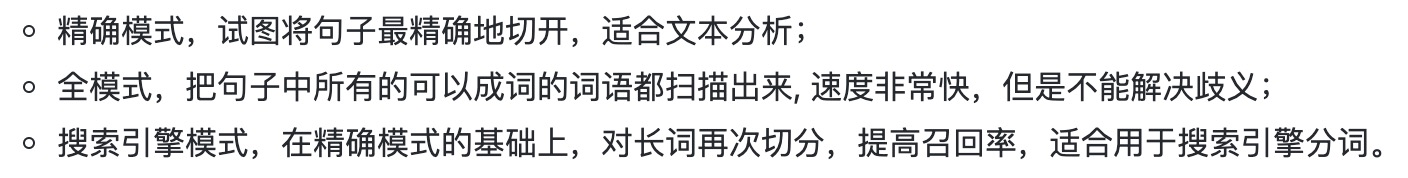

In [ ]:
# encoding=utf-8
import jieba

src_str = "小明硕士毕业于中国科学院计算所，后在日本京都大学深造"

seg_list = jieba.cut(src_str, cut_all=True)
print("【全模式】: " + ", ".join(seg_list))

seg_list = jieba.cut(src_str, cut_all=False)
print("【精确模式】: " + ", ".join(seg_list))

seg_list = jieba.cut(src_str)
print("【精确模式】: " + ", ".join(seg_list))

seg_list = jieba.cut_for_search(src_str)
print("【搜索引擎模式】: " + ", ".join(seg_list))

In [ ]:
from IPython.core.display import display, HTML
import bisect
from collections import defaultdict
import jieba

class MySearchV6(MySearchV5):
    """
    V0: Base class for Search Engine.
    V1: Data multiplication added.
    V2: Sorting optimization.
    V3: Add lowered version of docs.
    V4: For long doc.
    V5: Caching search results.
    V6: Pre-caching all words in docs.

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    pre_cache_all():
        Pre-caching all words in docs.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    get_word_match(self, keyword):
        get doc set containing keyword.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    """
    
    def __init__(self, filename, multi_factor=1):
        self.docs = []
        self.docs_lower = []
        self.search_cache = defaultdict(set)
        self.multi_factor = multi_factor #data multiplication factor(default 1)
        self.load_data(filename)
        self.pre_cache_all()
        
    def pre_cache_all(self):
        for tid, doc in enumerate(self.docs_lower):
            for word in jieba.cut_for_search(doc):
                self.search_cache[word].add(tid)

In [ ]:
searcher = MySearchV6('titles_l.txt', 10)

In [ ]:
len(searcher.search_cache)

In [ ]:
keyword = '汽车'
%time search_result = searcher.search(keyword)
%time search_result = searcher.search(keyword)

#### `初始化时间过长`如何解决？
#### - 用`序列化/反序列化`避免重复处理
#### - 对已缓存进行`增量更新`

In [ ]:
from IPython.core.display import display, HTML
import bisect
from collections import defaultdict
import jieba
import pickle

class MySearchV7(MySearchV6):
    """
    V0: Base class for Search Engine.
    V1: Data multiplication added.
    V2: Sorting optimization.
    V3: Add lowered version of docs.
    V4: For long doc.
    V5: Caching search results.
    V6: Pre-caching all words in docs.
    V7: Add Serialize/UnSerialize.

    Attributes
    ----------
    filename : str
        file name of doc data
    multi_factor : int
        data multiplication factor(default 1)

    Methods
    -------
    load_data(filename):
        load data from file.
    save_data(filename):
        save data to file
    pre_cache_all():
        Pre-caching all words in docs.
    highlight(text, keyword):
        highlight text with keyword.
    score(text, keyword):
        get score of text for a query.
    get_word_match(self, keyword):
        get doc set containing keyword.
    search(keyword, num=15):
        get top num search results of a query.
    render(result_list, keyword):
        output search results with highlight.
    """
    
    def __init__(self, filename, multi_factor=1):
        self.docs = []
        self.docs_lower = []
        self.search_cache = defaultdict(set)
        self.multi_factor = multi_factor
        self.load_data(filename)
        
    def load_data(self, filename):
        if filename[-3:] == 'txt':
            with open(filename, 'r') as f:
                self.docs = f.read().split('\n')
            self.docs_lower = [doc.lower() for doc in self.docs]
            self.docs = self.docs * self.multi_factor 
            self.docs_lower = self.docs_lower * self.multi_factor
            self.pre_cache_all()
        elif filename[-3:] == 'dat':
            with open(filename, 'rb') as f:
                self.docs, self.docs_lower, self.search_cache = pickle.load(f)
    def save_data(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump((self.docs, self.docs_lower, self.search_cache), f)

In [ ]:
searcher = MySearchV7('titles_l.txt', 1)

In [ ]:
searcher.save_data('titles.dat')

In [ ]:
len(searcher.search_cache)

In [ ]:
searcher = MySearchV7('titles.dat', 1)

In [ ]:
len(searcher.search_cache)

In [ ]:
keyword = 'iphone'
search_result = searcher.search(keyword, num=10)
searcher.render(search_result, keyword)